In [1]:
import numpy as np
import pandas as pd
# import volpriceinference as vl
import volprice as vl
import matplotlib as mpl
import seaborn as sns
import logging
import tqdm
from multiprocessing import Pool
import sys
from functools import partial
import cdpm

In [2]:
%matplotlib inline
mpl.style.use('seaborn-talk')
np.set_printoptions(precision=3)

In [3]:
logging.captureWarnings(True)
root_logger = logging.getLogger()
root_logger.setLevel(logging.INFO)
info_handler = logging.FileHandler('../logging.tmp.txt')
info_handler.addFilter(lambda record: record.levelno <= logging.WARNING)
error_handler = logging.StreamHandler(sys.stderr)
error_handler.addFilter(lambda record: record.levelno > logging.WARNING)
root_logger.addHandler(info_handler)
root_logger.addHandler(error_handler)

## Setup the True Parameters /  Simulation Parameters

In [4]:
kharpov = False

In [86]:
if kharpov:
    true_params = {'theta': 1.7680, 
               'pi': -10,
               'phi': -.3,
               'log_scale': np.log(252 * 1.564e-5),
#                 'log_scale' : np.log(.1),
                'log_both': np.log(0.6475) + np.log(252 * 1.564e-5),
               'rho': .5,
              }
else:
#     Daily
     true_params ={'log_both': 0.8819415995231439,
                   'log_scale': 1.7813838683227812,
                   'rho': 0.5294015291756116,
                   'phi': -0.29799406819991614,
#                    'pi': 0.05812774870906164,
                    'pi': 0, 
                   'theta': 0.43003184804533173}
#     Weekly
#     true_params = {'log_both': -0.2768983372209973 + 0.805773558068805,
#                    'log_scale': 0.805773558068805,
#                    'rho': 0.6097218157104826,
#                    'phi': -0.8999999994952989,
#                    # Here I use the daily value.
#                    'pi': -.01,
#                    'theta': 2.6348432313374923}
    
time_dim = 10000
sim_dim = 1000
innov_dim = 250

In [87]:
total_true_params = true_params.copy()
total_true_params.update(
    {'gamma': vl.compute_gamma(**true_params),
     'beta':vl.compute_beta(rho=true_params['rho'], log_scale=true_params['log_scale'],
                            phi=true_params['phi'], pi=true_params['pi'], theta=true_params['theta']),
     'psi':vl.compute_psi(rho=true_params['rho'], log_scale=true_params['log_scale'], phi=true_params['phi'], 
                  theta=true_params['theta']),
      'zeta': 1 - true_params['phi']**2})

In [88]:
def compute_moments(log_both, rho, log_scale, phi, pi, theta):
    
    vol_mean = np.exp(log_both) / (1 - rho)
    vol_var = (2 * np.exp(log_scale) * rho * vol_mean + np.exp(log_scale)**2 * np.exp(log_both - log_scale)) / (1 - rho**2)
    
    psi = vl.compute_psi(rho=rho, log_scale=log_scale, phi=phi, theta=theta)
    beta = vl.compute_beta(rho=rho, log_scale=log_scale, phi=phi, pi=pi, theta=theta)
    gamma = vl.compute_gamma(log_both=log_both, rho=rho, log_scale=log_scale, phi=phi, pi=pi, theta=theta)
    
    return_mean = psi * vol_mean + beta * vol_mean + gamma
    return_var = psi**2 * vol_var + beta**2 * vol_var  + (1 - phi**2) * vol_mean
    
    return {'return_mean': return_mean, 'return_var': return_var, 'vol_mean': vol_mean, 'vol_var': vol_var}

In [89]:
compute_moments(**true_params)

{'return_mean': 3.1317405877457967,
 'return_var': 31.549281175754267,
 'vol_mean': 5.133007022236617,
 'vol_var': 64.7689014371392}

In [90]:
vl.compute_gamma(**true_params)

0.6877523085562747

In [91]:
total_true_params

{'log_both': 0.8819415995231439,
 'log_scale': 1.7813838683227812,
 'rho': 0.5294015291756116,
 'phi': -0.29799406819991614,
 'pi': 0,
 'theta': 0.43003184804533173,
 'gamma': 0.6877523085562747,
 'beta': 0.6263577366724149,
 'psi': -0.15022585752205325,
 'zeta': 0.9111995353176637}

In [92]:
true_params

{'log_both': 0.8819415995231439,
 'log_scale': 1.7813838683227812,
 'rho': 0.5294015291756116,
 'phi': -0.29799406819991614,
 'pi': 0,
 'theta': 0.43003184804533173}

In [93]:
total_true_params

{'log_both': 0.8819415995231439,
 'log_scale': 1.7813838683227812,
 'rho': 0.5294015291756116,
 'phi': -0.29799406819991614,
 'pi': 0,
 'theta': 0.43003184804533173,
 'gamma': 0.6877523085562747,
 'beta': 0.6263577366724149,
 'psi': -0.15022585752205325,
 'zeta': 0.9111995353176637}

## We start by examining the distributions of simulated data

In [94]:
data = vl.simulate_data(time_dim=time_dim, **true_params)

In [95]:
data.corr()

,vol,rtn
vol,1.000000,0.256409
rtn,0.256409,1.000000


In [96]:
data.head()

,vol,rtn
2000-01-01,0.432262,4.161864
2000-01-02,3.857223,0.562621
2000-01-03,6.535828,0.238364
2000-01-04,21.786789,3.143493
2000-01-05,31.164830,5.239957


In [97]:
data.vol.var()

56.99604404419387

In [98]:
init_constants = vl.compute_init_constants(data.vol)

In [99]:
init_constants

{'log_both': 0.8988067157712798,
 'log_scale': 1.7708865240009146,
 'rho': 0.49675517047766204}

In [100]:
vl.compute_vol_gmm(data.vol, init_constants)

({'log_both': 0.8992022401299538,
  'log_scale': 1.7676676515557803,
  'rho': 0.496713841244282},
            log_both  log_scale       rho
 log_both   0.000810   0.000364 -0.000285
 log_scale  0.000364   0.000658 -0.000065
 rho       -0.000285  -0.000065  0.000262)

In [101]:
omega, omega_cov = vl.estimate_params(data)

In [102]:
omega

{'gamma': 0.6884623953414623,
 'beta': 0.6263162382192058,
 'psi': -0.148976970655779,
 'zeta': 0.9130735684692673,
 'log_both': 0.8992022401299538,
 'log_scale': 1.7676676515557803,
 'rho': 0.496713841244282}

In [103]:
omega_cov

,beta,gamma,log_both,log_scale,psi,rho,zeta
beta,1.034062e-08,-2.956019e-08,0.000000,0.000000,-4.283924e-09,0.000000,0.000000
gamma,-2.956019e-08,2.613418e-07,0.000000,0.000000,-2.398202e-08,0.000000,0.000000
log_both,0.000000e+00,0.000000e+00,0.000810,0.000364,0.000000e+00,-0.000285,0.000000
log_scale,0.000000e+00,0.000000e+00,0.000364,0.000658,0.000000e+00,-0.000065,0.000000
psi,-4.283924e-09,-2.398202e-08,0.000000,0.000000,1.872236e-05,0.000000,0.000000
rho,0.000000e+00,0.000000e+00,-0.000285,-0.000065,0.000000e+00,0.000262,0.000000
zeta,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000173


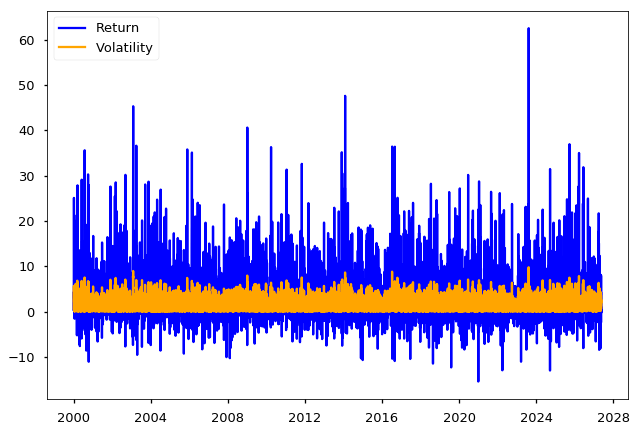

In [104]:
fig1, ax1 = mpl.pyplot.subplots()
ax1.plot(data.rtn, label='Return', color='blue')
ax1.plot(data.vol.apply(np.sqrt), label='Volatility', color='orange')

ax1.legend()

In [105]:
data.transform(lambda x: np.sqrt(x) if x.name == 'vol' else x).cov()

,vol,rtn
vol,1.997194,1.607648
rtn,1.607648,22.780113


In [106]:
total_true_params

{'log_both': 0.8819415995231439,
 'log_scale': 1.7813838683227812,
 'rho': 0.5294015291756116,
 'phi': -0.29799406819991614,
 'pi': 0,
 'theta': 0.43003184804533173,
 'gamma': 0.6877523085562747,
 'beta': 0.6263577366724149,
 'psi': -0.15022585752205325,
 'zeta': 0.9111995353176637}

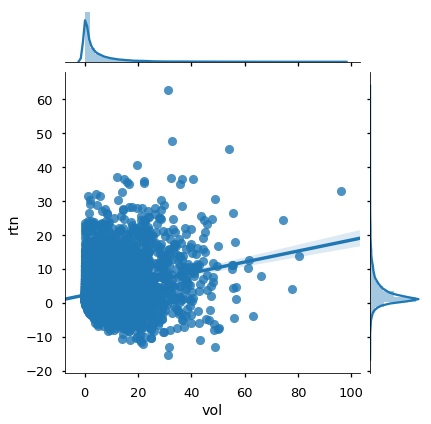

In [107]:
sns.jointplot(x='vol', y='rtn', data=data, kind='reg')

In [108]:
data.describe()

,vol,rtn
count,10000.000000,10000.000000
mean,4.880818,3.018344
std,7.549572,4.772852
min,0.000010,-15.405395
25%,0.310634,0.660067
50%,1.858351,1.685680
75%,6.200636,4.188949
max,96.021792,62.503041


## I now estimate all of the parameters

In [109]:
data_arr = [vl.simulate_data(time_dim=time_dim, **true_params)  for _ in tqdm.tnrange(sim_dim)]

In [110]:
def vol_estimator(data):
    return vl.compute_vol_gmm(data.vol, init_constants=vl.compute_init_constants(data.vol))

In [111]:
vol_estimator(data_arr[2])

({'log_both': 0.8956779754720492,
  'log_scale': 1.7430042024649937,
  'rho': 0.524324934954695},
            log_both  log_scale       rho
 log_both   0.000992   0.000390 -0.000364
 log_scale  0.000390   0.000634 -0.000081
 rho       -0.000364  -0.000081  0.000293)

In [112]:
with Pool(8) as pool:
    est_arr = list(tqdm.tqdm_notebook(pool.imap_unordered(vol_estimator, data_arr),
                                      total=len(data_arr)))

In [113]:
vol_params = pd.Series(true_params).loc[['log_both', 'log_scale', 'rho']]

In [114]:
ar_stats = [(pd.Series(est[0]) - vol_params) @ np.linalg.pinv(est[1]) @ (pd.Series(est[0]) - vol_params).T 
            for est in est_arr]

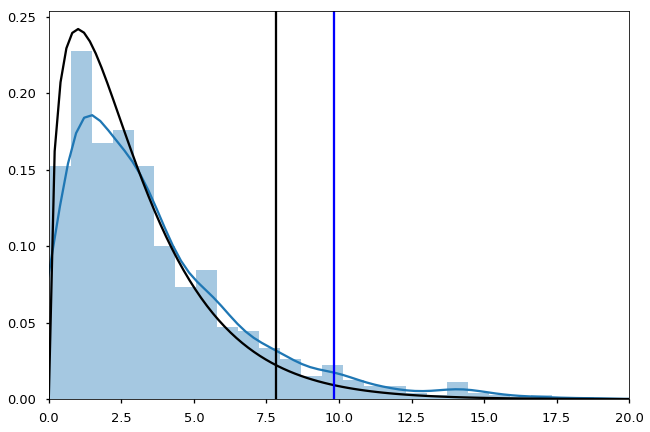

In [115]:
vol_fig, vol_ax = mpl.pyplot.subplots()
sns.distplot(ar_stats, ax=vol_ax)
vol_ax.plot(np.linspace(0, 20, 100), stats.chi2.pdf(np.linspace(0,20,100), df=3), color='black')
vol_ax.set_xlim([0,20])
vol_ax.axvline(stats.chi2.ppf(df=3, q=.95), color='black')
vol_ax.axvline(np.percentile(ar_stats, 95), color='blue')

In [116]:
100 * np.mean(stats.chi2.ppf(df=3, q=.95) < ar_stats)

9.9

In [84]:
t_stats = [(name, (est[0][name] - vol_params[name]) / np.sqrt(est[1].loc[name, name]) )
            for est in est_arr for name in ['rho', 'log_scale', 'log_both']]
t_stats_df = pd.DataFrame.from_records(t_stats).pivot(columns=0, values=1).ffill().bfill().iloc[::3,:]

In [85]:
vl.compute_init_constants(data.vol)

{'log_both': 0.9401242758203359,
 'log_scale': 1.818768020483836,
 'rho': 0.521948679386377}

In [38]:
true_params['log_both']

0.8819415995231439

In [39]:
np.amin([est[0]['log_both'] for est in est_arr])

0.258437280094353

In [40]:
t_stats_df.describe()

,log_both,log_scale,rho
count,1000.000000,1000.000000,1000.000000
mean,0.068179,-0.196208,-0.115491
std,1.169383,1.072893,1.211576
min,-8.962008,-3.878336,-4.604730
25%,-0.741268,-0.877245,-0.867086
50%,0.069087,-0.122439,-0.125152
75%,0.825420,0.558383,0.652343
max,4.863155,2.928686,11.995388


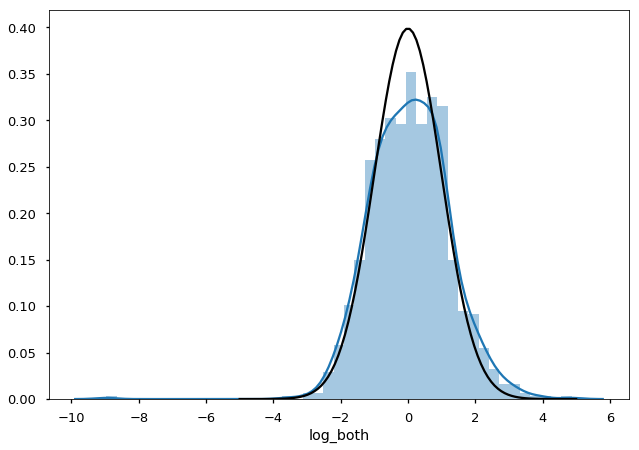

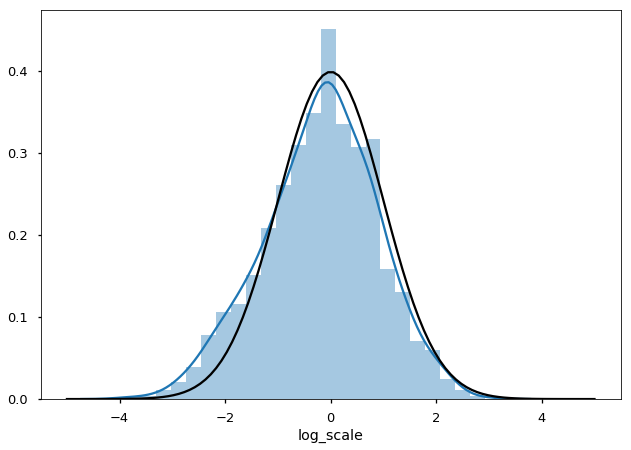

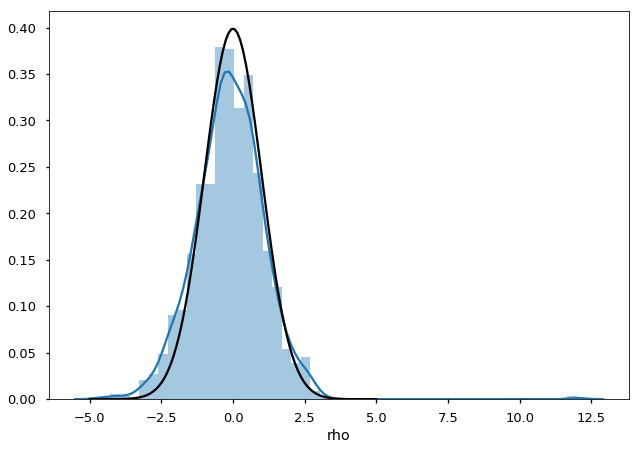

In [41]:
for name, col in t_stats_df.items():
    fig, ax = mpl.pyplot.subplots()
    sns.distplot(col, ax=ax)
    ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')

In [42]:
estimator = partial(vl.estimate_params_strong_id, case=1)

In [43]:
with Pool(8) as pool:
    est_arr = list(tqdm.tqdm_notebook(pool.imap_unordered(estimator, data_arr),
                                      total=len(data_arr)))

Process ForkPoolWorker-13:
Process ForkPoolWorker-14:
Process ForkPoolWorker-11:
Process ForkPoolWorker-9:
Process ForkPoolWorker-15:
Process ForkPoolWorker-16:
Process ForkPoolWorker-10:
Process ForkPoolWorker-12:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/sangrey/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/sangrey/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/sangrey/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/sangrey/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/home/sangrey/anac

KeyboardInterrupt: 

In [ ]:
def t_stats(x):
    mean = x.mean()
    cov = x.cov()
        
    return mean  / np.sqrt(np.diag(cov) / data.vol.size)

In [ ]:
moment_data = pd.DataFrame([t_stats(vl.vol_moments(data.vol, log_both=true_params['log_both'],
                                                   rho=true_params['rho'], log_scale=true_params['log_scale'])) 
                            for data in tqdm.tqdm_notebook(data_arr)])

In [ ]:
for name, moment in moment_data.items():
    moment_fig, moment_ax = mpl.pyplot.subplots()
    sns.distplot(moment, ax=moment_ax, bins=40)
    moment_ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')
    moment_ax.set_xlim([-4,4])

In [ ]:
with pd.option_context('mode.use_inf_as_null', True):
    for name in est_arr[0][0].keys():
        fig, ax = mpl.pyplot.subplots()       
        sns.distplot(pd.Series([(est[name] - total_true_params[name]) / np.sqrt(cov.loc[name,name])
                  for est, cov in est_arr]).dropna(), ax=ax, bins=40)
        ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')
        ax.set_xlabel(name)
#         if max(ax.get_xlim()) > 20:
#             ax.set_xlim(-20, 20)

In [ ]:
with pd.option_context('mode.use_inf_as_null', True):
    for name in ['phi', 'pi', 'theta']:
        fig, ax = mpl.pyplot.subplots()       
        sns.distplot(pd.Series([est[name] for est, cov in est_arr]).dropna(), ax=ax, bins=40)
        ax.set_xlabel(name)
        ax.axvline(total_true_params[name], color='black')
        if max(ax.get_xlim()) > 20:
            ax.set_xlim(-20, 20)

# I now compute the robust conditional QLR statistic 

In [ ]:
omega


In [ ]:
true_params

In [ ]:
compute_vals = partial(vl.compute_qlr_reject, true_prices=[true_params['phi'], true_params['pi'], 
                                                           true_params['theta']],
                      innov_dim=50, alpha=None, robust_quantile=True)

In [ ]:
def compute_ar(params, case=1):
    param_est, param_cov = params
    names = vl.compute_names(case)
    omega = {name: val for name, val in param_est.items() if name not in names}
    omega_cov = param_cov.query('index not in @names').T.query('index not in @names').T
    
    true_prices=[true_params['phi'], true_params['pi'], true_params['theta']]
    
    return vl._qlr_in(prices=true_prices, omega=omega, omega_cov=omega_cov, case=case)

In [ ]:
param_est, param_cov = est_arr[0]
names = vl.compute_names(1)
omega = {name: val for name, val in param_est.items() if name not in names}
omega_cov = param_cov.query('index not in @names').T.query('index not in @names').T
    
true_prices=[true_params['phi'], true_params['pi'], true_params['theta']]
# data.shape[0] * vl.covariance_kernel(true_prices, true_prices, omega_cov=omega_cov, omega=omega, case=1)
vl.compute_link(prices=true_prices, omega=omega, case=1)

In [ ]:
compute_ar(est_arr[0])

In [ ]:
with Pool(8) as pool:
    ar_results = pd.DataFrame(np.row_stack(list(tqdm.tqdm_notebook(pool.imap_unordered(compute_ar, est_arr),
                                                          total=len(est_arr)))))

In [ ]:
with pd.option_context('mode.use_inf_as_null', True):
    fig, ax = mpl.pyplot.subplots()       
    sns.distplot(ar_results.dropna(), ax=ax, bins=40)
    ax.plot(np.linspace(0,20,100), stats.chi2.pdf(np.linspace(0,20,100), df=4), color='black')

    ax.set_xlabel('AR Statistic Distribution')
    ax.set_xlim(0, 20)
    ax.axvline(np.percentile(ar_results, q=95), color='red')
    ax.axvline(stats.chi2.ppf(df=4, q=.95), color='green')

In [ ]:
# total=min(50, len(est_arr))
# with Pool(8) as pool:
#     results = pd.DataFrame(np.row_stack(list(tqdm.tqdm_notebook(pool.imap_unordered(compute_vals, 
#                                                                                     est_arr[:total]),
#                                                           total=total))))

In [ ]:
 stats.chi2.ppf(df=4, q=.95)

In [ ]:
100 * np.mean(ar_results > stats.chi2.ppf(df=4, q=.95))

In [ ]:
# results[results <=0] = 0 

In [ ]:
# robust_pit = cdpm.probability_integral_transform(evaluated_data = results.iloc[:,0].to_frame(),
#                                     reference_data=results.iloc[:,1:]).replace(np.inf, 1)

In [ ]:
# standard_pit = stats.chi2.cdf(results.iloc[:,0], df=3)

In [ ]:
# fig, ax = mpl.pyplot.subplots()
# cdpm.pit_plot(standard_pit, ax=ax, color='orange', hist_kws={'histtype':'step', 'alpha':1, 'linewidth':3},
#               label='standard')
# cdpm.pit_plot(robust_pit, ax=ax, color='blue', hist_kws={'histtype':'step', 'alpha':1, 'linewidth':3},
#               label='robust')
# ax.legend()
# fig.savefig('../doc/figures/asymptotic_dist_pitop_{}_{}.tmp.pdf'.format(innov_dim, true_params['phi']),
#             frameon=False, pad_inches=0, bbox_inches='tight', transparent=True)

In [ ]:
returnval = vl.compute_robust_rejection(est_arr, true_params, innov_dim=innov_dim, alpha=0.05, case=1,
                                        robust_quantile=True)

In [ ]:
returnval.head()

In [ ]:
returnval.head()

In [ ]:
returnval.mean()

In [ ]:
true_params['phi']

In [ ]:
if kharpov:
    filename = '../results/reject_prop_kharpov_{}_{}_{}.json'.format(innov_dim, true_params['phi'], 
                                                                         time_dim)
else:
    filename = '../results/reject_prop_{}_{}_{}.json'.format(innov_dim, true_params['phi'], 
                                                                         time_dim)
    
returnval.to_json(filename)

In [ ]:
returnval.mean()

In [ ]:
returnval.query('robust_qlr_qauntile > 0').mean()

In [ ]:
fig4, ax4 = mpl.pyplot.subplots()
try:
    sns.distplot(returnval.query('robust_qlr_qauntile > 0').robust_qlr_qauntile, 
                 kde_kws={"color": "red", "lw": 3, 'cumulative':True}, ax=ax4,hist=False, 
                 label='Robust Conditional Quantile')
           
except AttributeError:
    pass

sns.distplot(returnval.qlr_stat, hist=False, ax=ax4,kde_kws={"color": "blue", "lw": 3, 'cumulative':True},
      label='QLR Statistic')
ax4.axvline(stats.chi2.ppf(.95, df=3), color='black', label='Standard Quantile')
ax4.axvline(np.percentile(returnval.qlr_stat, 95),  color='Blue', label='Quantile in the data')

xvals = np.linspace(0, 20, 500)
ax4.plot(xvals, [stats.chi2.cdf(x, df=3) for x in xvals], color='green', label='$\chi^2(3)$ distribution')
ax4.set_xlim([0,50])
# ax4.set_ylim([0,.5])
ax4.set_xlabel("")
ax4.legend()
fig4.savefig('../doc/figures/reject_prop_{}_{}.tmp.pdf'.format(innov_dim, true_params['phi']),
            frameon=False, pad_inches=0, bbox_inces='tight', transparent=True)